# ML modeling

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

In [2]:
if IN_COLAB:
    !pip install git+https://github.com/MaxHalford/Prince
    !pip install -U imbalanced-learn

In [3]:
# Importing libraries
%matplotlib inline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from prince import FAMD
import tensorflow as tf
import pandas as pd
import numpy as np
from scipy.stats import mode, mannwhitneyu
from prince import FAMD
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Data loading

In [4]:
if IN_COLAB:

    # For using this you must upload the file to the temporary file system
    df = pd.read_csv('/content/dataset_after_enrichment.csv.zip',
                  compression='zip')
  
else:

    df = pd.read_csv(os.path.join(os.getcwd(),
                          os.pardir,
                          'data',
                          'transformed',
                          'dataset_after_enrichment.csv.zip'),
          compression='zip')

In [5]:
df.head()

,source_reduction_general_category,description_code,2_digit_naics,AUTOCORR2D_1,AUTOCORR2D_10,AUTOCORR2D_100,AUTOCORR2D_101,AUTOCORR2D_102,AUTOCORR2D_103,AUTOCORR2D_104,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,qed
0,Good Operating Practices,"greater than or equal 5%, but less than to 15%","Mining, Quarrying, and Oil and Gas Extraction",0.847,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.360624
1,Spill and Leak Prevention,"greater than or equal 5%, but less than to 15%","Mining, Quarrying, and Oil and Gas Extraction",0.847,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.360624
2,Process Modifications,"greater than or equal to 50%, but less than 100%","Mining, Quarrying, and Oil and Gas Extraction",0.847,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.360624
3,Process Modifications,"greater than or equal to 50%, but less than 100%","Mining, Quarrying, and Oil and Gas Extraction",0.847,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.360624
4,Process Modifications,"greater than 0%, but less than 5%",Utilities,0.847,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.360624


In [6]:
srgc_to_number = {val: i for i, val in enumerate(df['source_reduction_general_category'].unique())}
srgc_to_number

{'Good Operating Practices': 0,
 'Spill and Leak Prevention': 1,
 'Process Modifications': 2,
 'Raw Material Modifications': 3,
 'Inventory Control': 4,
 'Cleaning and Degreasing': 5,
 'Surface Preparation and Finishing': 6,
 'Product Modifications': 7}

In [7]:
 df['source_reduction_general_category'] = df['source_reduction_general_category'].map(srgc_to_number)

In [8]:
rc_to_number = {
    'greater than 0%, but less than 5%': '1',
    'greater than or equal 5%, but less than to 15%': '2',
    'greater than or equal 15%, but less than to 25%': '3',
    'greater than or equal to 25%, but less than 50%': '4',
    'greater than or equal to 50%, but less than 100%': '5',
    '100% (elimination of the chemical)': '6'
}
df['description_code'] = df['description_code'].map(rc_to_number)

In [9]:
sector_to_number = {val: str(i) for i, val in enumerate(df['2_digit_naics'].unique())}
sector_to_number

{'Mining, Quarrying, and Oil and Gas Extraction': '0',
 'Utilities': '1',
 'Manufacturing': '2',
 'Wholesale Trade': '3',
 'Professional, Scientific, and Technical Services': '4',
 'Administrative and Support and Waste Management and Remediation Services': '5',
 'Other Services (except Public Administration)': '6',
 'Public Administration (not covered in economic census)': '7',
 'Agriculture, Forestry, Fishing and Hunting (not covered in economic census)': '8',
 'Transportation and Warehousing': '9',
 'Educational Services': '10',
 'Health Care and Social Assistance': '11',
 'Information': '12'}

In [10]:
 df['2_digit_naics'] = df['2_digit_naics'].map(sector_to_number)

In [11]:
fcols = df.select_dtypes('float').columns
icols = df.select_dtypes('integer').columns

In [12]:
df[fcols] = df[fcols].apply(pd.to_numeric, downcast='float')
df[icols] = df[icols].apply(pd.to_numeric, downcast='integer')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 965300 entries, 0 to 965299
Columns: 403 entries, source_reduction_general_category to qed
dtypes: float32(296), int16(1), int8(104), object(2)
memory usage: 1.2+ GB


## 2. Checking for missing data

In [14]:
to_impute  = df.columns[df.isna().sum(axis=0) != 0].tolist()

In [15]:
to_impute 

['BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BCUT2D_MRLOW',
 'BCUT2D_MWHI',
 'BCUT2D_MWLOW',
 'MaxAbsPartialCharge',
 'MaxPartialCharge',
 'MinAbsPartialCharge',
 'MinPartialCharge']

In [16]:
len(to_impute )

12

In [17]:
df[to_impute ].isna().sum()*100/df.shape[0]

BCUT2D_CHGHI           10.152284
BCUT2D_CHGLO           10.152284
BCUT2D_LOGPHI          10.152284
BCUT2D_LOGPLOW         10.152284
BCUT2D_MRHI            10.152284
BCUT2D_MRLOW           10.152284
BCUT2D_MWHI            10.152284
BCUT2D_MWLOW           10.152284
MaxAbsPartialCharge     3.553299
MaxPartialCharge        3.553299
MinAbsPartialCharge     3.553299
MinPartialCharge        3.553299
dtype: float64

In [18]:
df[to_impute ].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 965300 entries, 0 to 965299
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   BCUT2D_CHGHI         867300 non-null  float32
 1   BCUT2D_CHGLO         867300 non-null  float32
 2   BCUT2D_LOGPHI        867300 non-null  float32
 3   BCUT2D_LOGPLOW       867300 non-null  float32
 4   BCUT2D_MRHI          867300 non-null  float32
 5   BCUT2D_MRLOW         867300 non-null  float32
 6   BCUT2D_MWHI          867300 non-null  float32
 7   BCUT2D_MWLOW         867300 non-null  float32
 8   MaxAbsPartialCharge  931000 non-null  float32
 9   MaxPartialCharge     931000 non-null  float32
 10  MinAbsPartialCharge  931000 non-null  float32
 11  MinPartialCharge     931000 non-null  float32
dtypes: float32(12)
memory usage: 44.2 MB


As you can see, there are 12 columns with missing values. The missing values do not exceed 10.16% of the samples. Thus, let's apply lazy imputation using the median (less susceptible to outliers) for floats.

In [19]:
df[to_impute] = df[to_impute].fillna({to_impute[idx]: val for idx, val in enumerate(np.nanmedian(df[to_impute].values, axis=0))})

In [20]:
len(df.columns[df.isna().sum(axis=0) != 0].tolist())

0

## 3. Removing duplicate rows

In [21]:
df.drop_duplicates(keep='first', inplace=True)
df.reset_index(drop=True, inplace=True)

In [22]:
df.shape

(24511, 403)

## 4. Removing outliers

Altough there are distance-based methods that work well for identifying outliers for mixed data, here I will use a tree-based method, which works faster.

In [23]:
outlier_detection = IsolationForest(max_samples=100,
                                    random_state=0,
                                    contamination=0.2)

In [24]:
feature_cols = [col for col in df.columns if (col != 'source_reduction_general_category')]
feature_dtype = df[feature_cols].dtypes.apply(lambda x: x.name).to_dict()

In [25]:
df_outliers = df[feature_cols].copy()

In [26]:
for c, t in feature_dtype.items():
    if t == 'object': 
        df_outliers = pd.concat([df_outliers, pd.get_dummies(df_outliers[c],
                                    sparse=False)],
                axis=1)
        df_outliers.drop(columns=[c],
            inplace=True)

In [27]:
outlier_detection.fit(df_outliers.values)
filters = outlier_detection.predict(df_outliers.values)

In [28]:
del df_outliers
df = df[filters==1]

In [29]:
X = df[feature_cols]
y = df['source_reduction_general_category']
del df

## 5. Train-test splitting

To conserve the distribution of the dataset, the train test split will be stratified

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0,
                                                    shuffle=True,
                                                    stratify=y)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

## 6. Dimensionality reduction by Factor analysis of mixed data (FAMD)

Let's reduce the dimensionality of the features. For this, I will apply a feature transformation method. As the data set is mixed (i.e., have both categorical and numerical variables), Principal Components Analysis would not be a good method for reducing the dataset dimensions. Thus, I will apply Factor analysis of mixed data (FAMD). After FAMD, only will keep those components whose sum of explained variances is at least equal to 0.95   

In [31]:
famd = FAMD(n_components=X_train.shape[1],  n_iter=3,
            copy=True, check_input=True,
            engine='auto',  random_state=42)
famd.fit(X_train)

FAMD(n_components=402, random_state=42)

In [32]:
sum_explained_variance = 0
threshold = 0.95
for components_idx, variance in enumerate(famd.explained_inertia_):
    sum_explained_variance += variance
    if sum_explained_variance >= threshold:
        break

In [33]:
print(f'{components_idx} explain {sum_explained_variance} of the variance')

48 explain 0.9519376995982558 of the variance


In [34]:
X_train_reduced = famd.transform(X_train).values[:, 0:components_idx]
X_test_reduced = famd.transform(X_test).values[:, 0:components_idx]

## 7. Scaling after transformation

As you can see in the two cells just below, the components does not variate in the same scale. Thus, I will use max_min scaling, to not assume a normal distribution for the features.

In [35]:
X_train_reduced.min(axis=0)

array([-2.04093142, -2.17417685, -2.65969722, -1.88538732, -2.17203344,
       -2.48981679, -1.09075688, -1.80100656, -1.63322007, -2.40806505,
       -1.44127086, -3.25690042, -6.11845995, -2.33730064, -1.34876919,
       -2.05599168, -1.20921804, -1.7836005 , -1.75681121, -1.71149925,
       -1.22011367, -1.33160044, -1.10437112, -1.88516048, -1.14758492,
       -0.95649846, -1.1453465 , -0.9130226 , -0.94993371, -1.11456286,
       -0.88420174, -0.99602261, -0.90849825, -0.63282049, -0.82897077,
       -0.78004122, -0.93594082, -0.53734016, -0.68720319, -0.84117703,
       -0.73913971, -0.65502737, -0.94532367, -0.62575444, -0.63268708,
       -0.9839131 , -0.68636561, -0.63416914])

In [36]:
X_train_reduced.max(axis=0)

array([4.90875285, 2.71459137, 3.39011818, 3.46577691, 3.30431866,
       3.18958122, 1.85733781, 2.17286571, 3.83083388, 2.56515167,
       6.06336575, 3.63000693, 6.13103276, 2.9802107 , 2.41485235,
       2.77230869, 2.42196951, 3.32063375, 4.38827955, 2.22552525,
       1.7937078 , 1.3969918 , 1.63272987, 4.15678498, 1.25910149,
       1.94614392, 1.49338858, 1.27171603, 1.25770528, 1.51155641,
       1.12267366, 1.75376239, 1.09166144, 1.18430303, 1.46483155,
       1.0108988 , 1.04239916, 0.91301471, 1.36245135, 1.12657545,
       0.77249839, 0.80223961, 1.21023725, 1.32585412, 0.67032352,
       3.04306971, 1.23598854, 1.00447884])

In [37]:
scalerMinMax = MinMaxScaler()

In [38]:
scalerMinMax.fit(X_train_reduced)

MinMaxScaler()

In [39]:
X_train_scaled = scalerMinMax.transform(X_train_reduced)
X_test_scaled = scalerMinMax.transform(X_test_reduced)

## 8. Balancing (data augmentation)

As the EDA shows, the data set is unbalanced. Therefore, I will use the synthetic minority oversampling technique (SMOTE), which is an oversampling technique widely used by ML practitioners for balacing the datasets for classification tasks.

In [40]:
smote = SMOTE(random_state=42, n_jobs=-1)
X_balanced, y_balanced = smote.fit_resample(X_train_scaled, y_train)

In [41]:
y_balanced.value_counts()

7    3459
6    3459
5    3459
4    3459
3    3459
2    3459
1    3459
0    3459
Name: source_reduction_general_category, dtype: int64

## 9. Modeling

In [42]:
y_balanced = y_balanced.values.reshape((y_balanced.shape[0], 1))

In [43]:
y_test = y_test.values.reshape((y_test.shape[0], 1))

### 9.1. Model

For classification I will use the Artificial Neural Network Classifier (ANNC). I will provide:

1. The alternative to include one or more hidden layers with different number of neurons.
2. The option to incorporate dropout layers to handle overfitting.
3. The normalization of the bath which has been shown to improve model performance.
4. I will use the Adam optimizer which is widely used by deep learning engineers.

5. The output layer will use a softmax activation function and the loss function will be Categorical Cross-Entropy.

In [44]:
def annclassifier(units_per_layer, dropout, dropout_rate,
                  hidden_layers_activation, learning_rate,
                  beta_1, beta_2, input_shape, output_shape):
    '''
    Function to build the Artificial Neural Network Classifier
    '''

    # Selecting weights initilizer
    if hidden_layers_activation == 'sigmoid':
        initializer = tf.keras.initializers.GlorotNormal(seed=0)
    else:
        initializer = tf.keras.initializers.VarianceScaling(seed=0)

    # Initialize model
    model = tf.keras.Sequential()

    # Input layer
    model.add(
        tf.keras.Input(shape=(input_shape,))
                )
    
    # Hidden layers
    n_hidden_layers = len(units_per_layer)
    for i in range(n_hidden_layers):
        if dropout[i]:
            model.add(
                tf.keras.layers.Dropout(dropout_rate, seed=0)
                )
        else:
            pass
        model.add(
            tf.keras.layers.Dense(units=units_per_layer[i],
                                activation=hidden_layers_activation,
                                kernel_initializer=initializer)
        )
        model.add(
            tf.keras.layers.BatchNormalization()
        )

    # Output layer
    model.add(
        tf.keras.layers.Dense(units=output_shape,
                              activation='softmax')
    )

    # Optimizer
    optimizer = tf.keras.optimizers.Adam(
                learning_rate=learning_rate,
                beta_1=beta_1,
                beta_2=beta_2,
            )

    # Compiling the model
    model.compile(optimizer=optimizer, 
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy'])


    return model

In [45]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if logs.get('val_accuracy') >= 0.70:
          print("Reached 70% accuracy so cancelling training!")
          self.model.stop_training = True

### 9.2 5-fold cross validation and hyperparameter tuning

Let's check the effect of the first hidden layer in the classification performance. The first layer of the ANNC is for finding out the decision boundary. If the boundary is hard to find the first layer will require many neurons. The following layers help to encode the first layer result to the ANNC output. For the following experiments, dropout will not be used, only 50 epochs will be implemented, and relu will be the activation function for the hidden layers.

#### 1 hidden layer - 32, 128, 512, or 2048 neurons

In [149]:
accuracy_train_dict = {}
accuracy_validation_dict = {}


for hidden_layers in [1, 2, 3, 4]:
    for neurons in [32, 128, 512, 2048]:

        print(f'{hidden_layers} hidden layers with {neurons} neurons')
        model_params = {'units_per_layer': (neurons, )*hidden_layers,
                'dropout': (False, )*hidden_layers,
                'dropout_rate': 0.3,
                'hidden_layers_activation': 'relu',
                'learning_rate': 0.0001,
                'beta_1': 0.9,
                'beta_2': 0.999,
                'epochs': 50,
                'batch_size': 32,
                'verbose': 0}

        epochs = model_params['epochs']
        batch_size = model_params['batch_size']
        verbose = model_params['verbose']
        model_params.update({'input_shape': X_balanced.shape[1],
                             'output_shape': 8})
        model_params = {par: val for par, val in model_params.items() if par not in ['epochs', 'batch_size', 'verbose']}

        accuracy_train_list = []
        accuracy_validation_list = []

        skf = StratifiedKFold(n_splits=5, shuffle=True)

        for train_index, validation_index in skf.split(X_balanced, y_balanced):
            X_train, X_validation = X_balanced[train_index], X_balanced[validation_index]
            y_train, y_validation = y_balanced[train_index], y_balanced[validation_index]
            dd_model = annclassifier(**model_params)
            hist = dd_model.fit(X_train, y_train,
                                  batch_size=batch_size,
                                  verbose=verbose,
                                  epochs=epochs,
                                  validation_data=(X_validation, y_validation),
                                  shuffle=True,
                                  callbacks=[myCallback()])
            accuracy_validation_list.append(dd_model.evaluate(X_validation, y_validation, verbose=0)[1])
            accuracy_train_list.append(dd_model.evaluate(X_train, y_train, verbose=0)[1])

        accuracy_train_dict.update({(hidden_layers, neurons): accuracy_train_list})
        accuracy_validation_dict.update({(hidden_layers, neurons): accuracy_validation_list})

1 hidden layers with 32 neurons
1 hidden layers with 128 neurons
1 hidden layers with 512 neurons
1 hidden layers with 2048 neurons
2 hidden layers with 32 neurons
2 hidden layers with 128 neurons
2 hidden layers with 512 neurons
2 hidden layers with 2048 neurons
3 hidden layers with 32 neurons
3 hidden layers with 128 neurons
3 hidden layers with 512 neurons
3 hidden layers with 2048 neurons
4 hidden layers with 32 neurons
4 hidden layers with 128 neurons
4 hidden layers with 512 neurons
4 hidden layers with 2048 neurons


In [189]:
df_to_plot = pd.DataFrame(
                        {'params': [f'{key[0]} hidden layes - {key[1]} neurons' for key in accuracy_train_dict.keys() for _ in range(5)] + \
                                  [f'{key[0]} hidden layes - {key[1]} neurons' for key in accuracy_validation_dict.keys() for _ in range(5)], 
                        'accuracy': [val[i] for val in accuracy_train_dict.values() for i in range(5)] + \
                                    [val[i] for val in accuracy_validation_dict.values() for i in range(5)],
                        'set_type': ['train']*len(accuracy_train_dict.keys())*5 + \
                                ['validation']*len(accuracy_validation_dict.keys())*5}
                         )

df_to_plot.head()

,params,accuracy,set_type
0,1 hidden layes - 32 neurons,0.361928,train
1,1 hidden layes - 32 neurons,0.369020,train
2,1 hidden layes - 32 neurons,0.390279,train
3,1 hidden layes - 32 neurons,0.383278,train
4,1 hidden layes - 32 neurons,0.375463,train


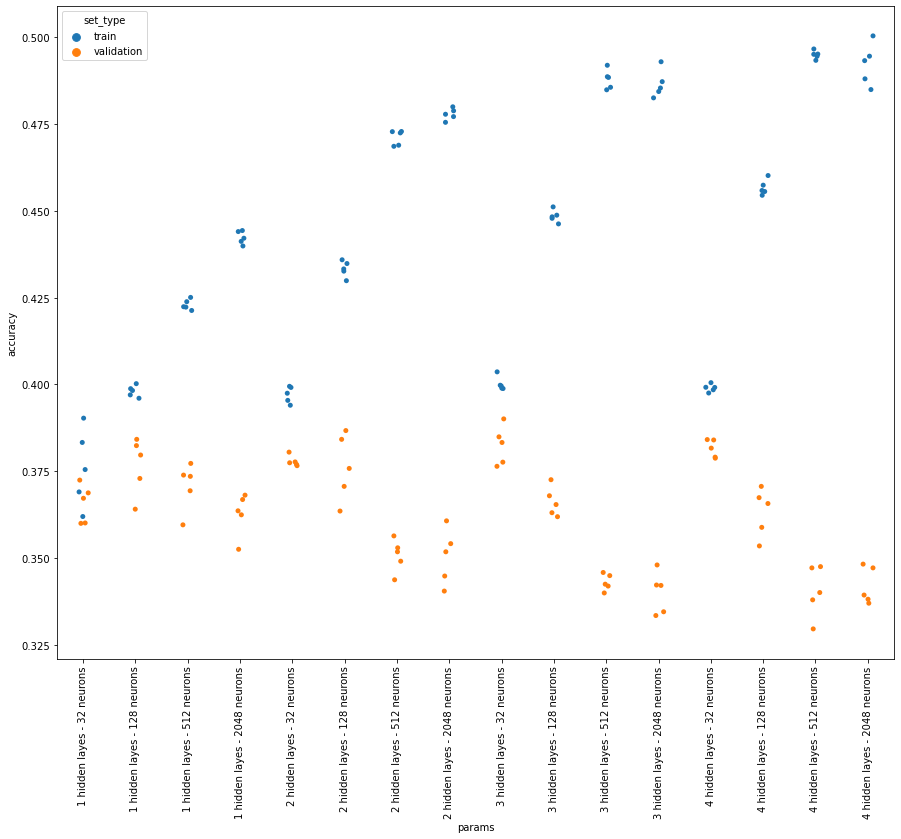

In [190]:
fig, ax = plt.subplots(figsize=(15, 12))
sns.stripplot(
           data=df_to_plot,
           x='params', 
           y='accuracy', 
           hue='set_type',
           jitter=True, 
           marker='o', 
           ax=ax
            )
plt.xticks(rotation=90)
plt.show()

The above figure depicts the following aspects:

1. The number of neurons used in the first layer can improve the recognition of the decision boundary. Nonetheless, it is important to be careful with the overfitting (the more neurons in the first layer, the greater the overfitting).
2. Increasing the number of hidden layers can significantly improve train set accuracy when the number of neurons is greater than 100. However, the trade-off is overfitting.
3. The use of a fourth hidden layer will not represent a considerable improvement in model performance.
5. If many neurons are used and the number of hidden layers is increased, the performance of the model in the validation set would suffer (it could even decrease and get stuck).

Now, the decision is to run experiments for a 3-hidden-layer ANNC with 2048-512-128 neurons for each layer.

#### 3-hidden-layer ANNC (2048-512-128) with and without dropout

Let's run experiments involving a fixed dropout rate of 30%.

In [193]:
accuracy_train_dict = {}
accuracy_validation_dict = {}

experiments = {'None': (False, False, False),
             '1-first': (True, False, False),
             '1-second': (False, True, False),
             '1-Third': (False, False, True),
             '2-first-second': (True, True, False),
             '2-first-third': (True, False, True),
             '2-second-third': (False, True, True),
             'All': (True, True, True)}

for experiment, dropout in experiments.items():

    print(experiment)

    model_params = {'units_per_layer': (2048, 512, 128),
            'dropout': dropout,
            'dropout_rate': 0.3,
            'hidden_layers_activation': 'relu',
            'learning_rate': 0.0001,
            'beta_1': 0.9,
            'beta_2': 0.999,
            'epochs': 10,
            'batch_size': 32,
            'verbose': 0}

    epochs = model_params['epochs']
    batch_size = model_params['batch_size']
    verbose = model_params['verbose']
    model_params.update({'input_shape': X_balanced.shape[1],
                         'output_shape': 8})
    model_params = {par: val for par, val in model_params.items() if par not in ['epochs', 'batch_size', 'verbose']}

    accuracy_train_list = []
    accuracy_validation_list = []

    skf = StratifiedKFold(n_splits=5, shuffle=True)

    for train_index, validation_index in skf.split(X_balanced, y_balanced):
        X_train, X_validation = X_balanced[train_index], X_balanced[validation_index]
        y_train, y_validation = y_balanced[train_index], y_balanced[validation_index]
        dd_model = annclassifier(**model_params)
        hist = dd_model.fit(X_train, y_train,
                              batch_size=batch_size,
                              verbose=verbose,
                              epochs=epochs,
                              validation_data=(X_validation, y_validation),
                              shuffle=True,
                              callbacks=[myCallback()])
        accuracy_validation_list.append(dd_model.evaluate(X_validation, y_validation, verbose=0)[1])
        accuracy_train_list.append(dd_model.evaluate(X_train, y_train, verbose=0)[1])

    accuracy_train_dict.update({experiment: accuracy_train_list})
    accuracy_validation_dict.update({experiment: accuracy_validation_list})

None
1-first
1-second
1-Third
2-first-second
2-first-third
2-second-third
All


In [194]:
df_to_plot2 = pd.DataFrame(
                        {'params': [key for key in accuracy_train_dict.keys() for _ in range(5)] + \
                                   [key for key in accuracy_validation_dict.keys() for _ in range(5)], 
                        'accuracy': [val[i] for val in accuracy_train_dict.values() for i in range(5)] + \
                                    [val[i] for val in accuracy_validation_dict.values() for i in range(5)],
                        'set_type': ['train']*len(accuracy_train_dict.keys())*5 + \
                                ['validation']*len(accuracy_validation_dict.keys())*5}
                         )

df_to_plot2.head()

,params,accuracy,set_type
0,None,0.445453,train
1,None,0.441839,train
2,None,0.436851,train
3,None,0.437483,train
4,None,0.445524,train


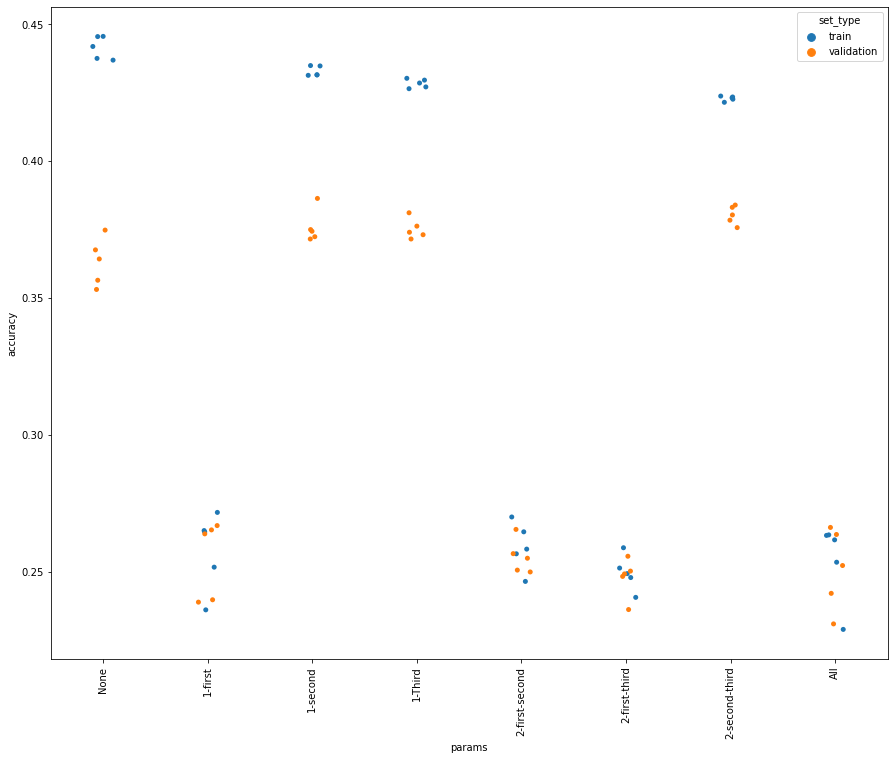

In [196]:
fig2, ax2 = plt.subplots(figsize=(15, 12))
sns.stripplot(
           data=df_to_plot2,
           x='params', 
           y='accuracy', 
           hue='set_type',
           jitter=True, 
           marker='o', 
           ax=ax2
            )
plt.xticks(rotation=90)
plt.show()

As you can see:

1. Dropout helps to reduce the overfitting leading to the clouds representing the accuracy of the train and validation sets overlapping.
2. The overfitting is specially reduce when the first hidden layer is subject to dropout, but the accuracy is drastically decrease around 25% for 10 epochs.
3. If the second and third hidden layers are subject to dropout could represent a good trade-off between accuracy and overfitting.

#### 3-hidden-layer ANNC (2048-512-128) with dropout on the second and third layer: 0.1, 0.2, 0.3, 0.4, and 0.5 dropout rates

In [197]:
accuracy_train_dict = {}
accuracy_validation_dict = {}

experiments = {'0.1': 0.1,
             '0.2': 0.2,
             '0.3': 0.3,
             '0.4': 0.4,
             '0.5': 0.5}

for experiment, dropout_rate in experiments.items():

    print(experiment)

    model_params = {'units_per_layer': (2048, 512, 128),
            'dropout': (False, True, True),
            'dropout_rate': dropout_rate,
            'hidden_layers_activation': 'relu',
            'learning_rate': 0.0001,
            'beta_1': 0.9,
            'beta_2': 0.999,
            'epochs': 10,
            'batch_size': 32,
            'verbose': 0}

    epochs = model_params['epochs']
    batch_size = model_params['batch_size']
    verbose = model_params['verbose']
    model_params.update({'input_shape': X_balanced.shape[1],
                         'output_shape': 8})
    model_params = {par: val for par, val in model_params.items() if par not in ['epochs', 'batch_size', 'verbose']}

    accuracy_train_list = []
    accuracy_validation_list = []

    skf = StratifiedKFold(n_splits=5, shuffle=True)

    for train_index, validation_index in skf.split(X_balanced, y_balanced):
        X_train, X_validation = X_balanced[train_index], X_balanced[validation_index]
        y_train, y_validation = y_balanced[train_index], y_balanced[validation_index]
        dd_model = annclassifier(**model_params)
        hist = dd_model.fit(X_train, y_train,
                              batch_size=batch_size,
                              verbose=verbose,
                              epochs=epochs,
                              validation_data=(X_validation, y_validation),
                              shuffle=True,
                              callbacks=[myCallback()])
        accuracy_validation_list.append(dd_model.evaluate(X_validation, y_validation, verbose=0)[1])
        accuracy_train_list.append(dd_model.evaluate(X_train, y_train, verbose=0)[1])

    accuracy_train_dict.update({experiment: accuracy_train_list})
    accuracy_validation_dict.update({experiment: accuracy_validation_list})

0.1
0.2
0.3
0.4
0.5


In [198]:
df_to_plot3 = pd.DataFrame(
                        {'params': [key for key in accuracy_train_dict.keys() for _ in range(5)] + \
                                   [key for key in accuracy_validation_dict.keys() for _ in range(5)], 
                        'accuracy': [val[i] for val in accuracy_train_dict.values() for i in range(5)] + \
                                    [val[i] for val in accuracy_validation_dict.values() for i in range(5)],
                        'set_type': ['train']*len(accuracy_train_dict.keys())*5 + \
                                ['validation']*len(accuracy_validation_dict.keys())*5}
                         )

df_to_plot3.head()

,params,accuracy,set_type
0,0.1,0.434521,train
1,0.1,0.434973,train
2,0.1,0.436038,train
3,0.1,0.432063,train
4,0.1,0.438522,train


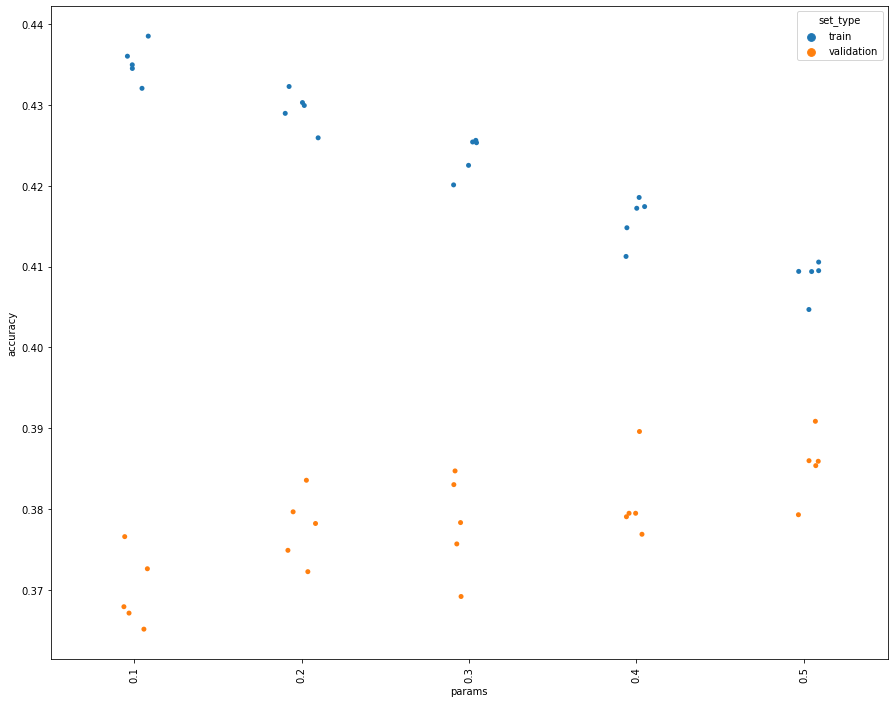

In [199]:
fig3, ax3 = plt.subplots(figsize=(15, 12))
sns.stripplot(
           data=df_to_plot3,
           x='params', 
           y='accuracy', 
           hue='set_type',
           jitter=True, 
           marker='o', 
           ax=ax3
            )
plt.xticks(rotation=90)
plt.show()

As can be seen, increasing the dropout rate above 0.2 may not significantly increase the accuracy of validation.

#### 3-hidden-layer ANNC (2048-512-128) with dropout on the second and third layer with a dropout rate of 0.2: learning rates 0.00001, 0.0001, and 0.001

In [201]:
accuracy_train_dict = {}
accuracy_validation_dict = {}

experiments = {'Learning rate 0.00001': 0.00001,
             'Learning rate 0.0001': 0.0001,
             'Learning rate 0.001': 0.001}

for experiment, lr_rate in experiments.items():

    print(experiment)

    model_params = {'units_per_layer': (2048, 512, 128),
            'dropout': (False, True, True),
            'dropout_rate': 0.2,
            'hidden_layers_activation': 'relu',
            'learning_rate': lr_rate,
            'beta_1': 0.9,
            'beta_2': 0.999,
            'epochs': 10,
            'batch_size': 32,
            'verbose': 0}

    epochs = model_params['epochs']
    batch_size = model_params['batch_size']
    verbose = model_params['verbose']
    model_params.update({'input_shape': X_balanced.shape[1],
                         'output_shape': 8})
    model_params = {par: val for par, val in model_params.items() if par not in ['epochs', 'batch_size', 'verbose']}

    accuracy_train_list = []
    accuracy_validation_list = []

    skf = StratifiedKFold(n_splits=5, shuffle=True)

    for train_index, validation_index in skf.split(X_balanced, y_balanced):
        X_train, X_validation = X_balanced[train_index], X_balanced[validation_index]
        y_train, y_validation = y_balanced[train_index], y_balanced[validation_index]
        dd_model = annclassifier(**model_params)
        hist = dd_model.fit(X_train, y_train,
                              batch_size=batch_size,
                              verbose=verbose,
                              epochs=epochs,
                              validation_data=(X_validation, y_validation),
                              shuffle=True,
                              callbacks=[myCallback()])
        accuracy_validation_list.append(dd_model.evaluate(X_validation, y_validation, verbose=0)[1])
        accuracy_train_list.append(dd_model.evaluate(X_train, y_train, verbose=0)[1])

    accuracy_train_dict.update({experiment: accuracy_train_list})
    accuracy_validation_dict.update({experiment: accuracy_validation_list})

Learning rate 0.00001
Learning rate 0.0001
Learning rate 0.001


In [202]:
df_to_plot4 = pd.DataFrame(
                        {'params': [key for key in accuracy_train_dict.keys() for _ in range(5)] + \
                                   [key for key in accuracy_validation_dict.keys() for _ in range(5)], 
                        'accuracy': [val[i] for val in accuracy_train_dict.values() for i in range(5)] + \
                                    [val[i] for val in accuracy_validation_dict.values() for i in range(5)],
                        'set_type': ['train']*len(accuracy_train_dict.keys())*5 + \
                                ['validation']*len(accuracy_validation_dict.keys())*5}
                         )

df_to_plot4.head()

,params,accuracy,set_type
0,Learning rate 0.00001,0.413832,train
1,Learning rate 0.00001,0.416813,train
2,Learning rate 0.00001,0.408212,train
3,Learning rate 0.00001,0.413045,train
4,Learning rate 0.00001,0.410154,train


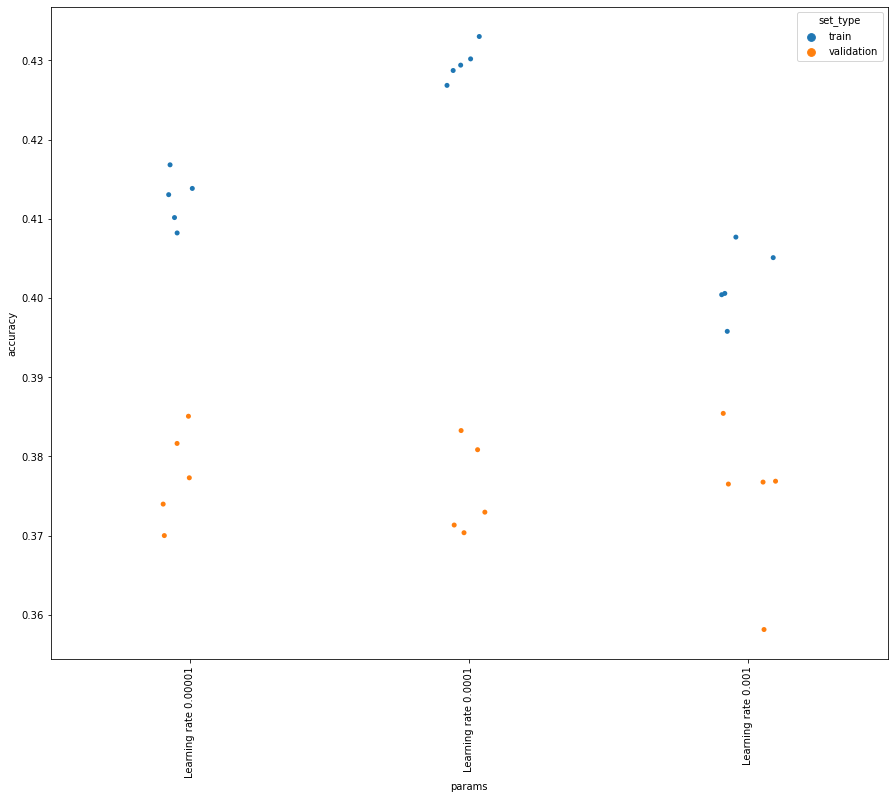

In [203]:
fig4, ax4 = plt.subplots(figsize=(15, 12))
sns.stripplot(
           data=df_to_plot4,
           x='params', 
           y='accuracy', 
           hue='set_type',
           jitter=True, 
           marker='o', 
           ax=ax4
            )
plt.xticks(rotation=90)
plt.show()

Although the learning rate seems to affect the accuracy of the train set, it does not affect so much the validation accuracy. In addition, a high learning rate may lead the optimization to get stuck.

In [204]:
accuracy_train_dict = {}
accuracy_validation_dict = {}

experiments = {'batch size 10': 10,
             'batch size 32': 32,
             'batch size 50': 50,
             'batch size 100': 100}

for experiment, batch_size in experiments.items():

    print(experiment)

    model_params = {'units_per_layer': (2048, 512, 128),
            'dropout': (False, True, True),
            'dropout_rate': 0.2,
            'hidden_layers_activation': 'relu',
            'learning_rate': 0.0001,
            'beta_1': 0.9,
            'beta_2': 0.999,
            'epochs': 10,
            'batch_size': batch_size,
            'verbose': 0}

    epochs = model_params['epochs']
    batch_size = model_params['batch_size']
    verbose = model_params['verbose']
    model_params.update({'input_shape': X_balanced.shape[1],
                         'output_shape': 8})
    model_params = {par: val for par, val in model_params.items() if par not in ['epochs', 'batch_size', 'verbose']}

    accuracy_train_list = []
    accuracy_validation_list = []

    skf = StratifiedKFold(n_splits=5, shuffle=True)

    for train_index, validation_index in skf.split(X_balanced, y_balanced):
        X_train, X_validation = X_balanced[train_index], X_balanced[validation_index]
        y_train, y_validation = y_balanced[train_index], y_balanced[validation_index]
        dd_model = annclassifier(**model_params)
        hist = dd_model.fit(X_train, y_train,
                              batch_size=batch_size,
                              verbose=verbose,
                              epochs=epochs,
                              validation_data=(X_validation, y_validation),
                              shuffle=True,
                              callbacks=[myCallback()])
        accuracy_validation_list.append(dd_model.evaluate(X_validation, y_validation, verbose=0)[1])
        accuracy_train_list.append(dd_model.evaluate(X_train, y_train, verbose=0)[1])

    accuracy_train_dict.update({experiment: accuracy_train_list})
    accuracy_validation_dict.update({experiment: accuracy_validation_list})

batch size 10
batch size 32
batch size 50
batch size 100


In [205]:
df_to_plot5 = pd.DataFrame(
                        {'params': [key for key in accuracy_train_dict.keys() for _ in range(5)] + \
                                   [key for key in accuracy_validation_dict.keys() for _ in range(5)], 
                        'accuracy': [val[i] for val in accuracy_train_dict.values() for i in range(5)] + \
                                    [val[i] for val in accuracy_validation_dict.values() for i in range(5)],
                        'set_type': ['train']*len(accuracy_train_dict.keys())*5 + \
                                ['validation']*len(accuracy_validation_dict.keys())*5}
                         )

df_to_plot5.head()

,params,accuracy,set_type
0,batch size 10,0.408592,train
1,batch size 10,0.414826,train
2,batch size 10,0.413362,train
3,batch size 10,0.414943,train
4,batch size 10,0.412323,train


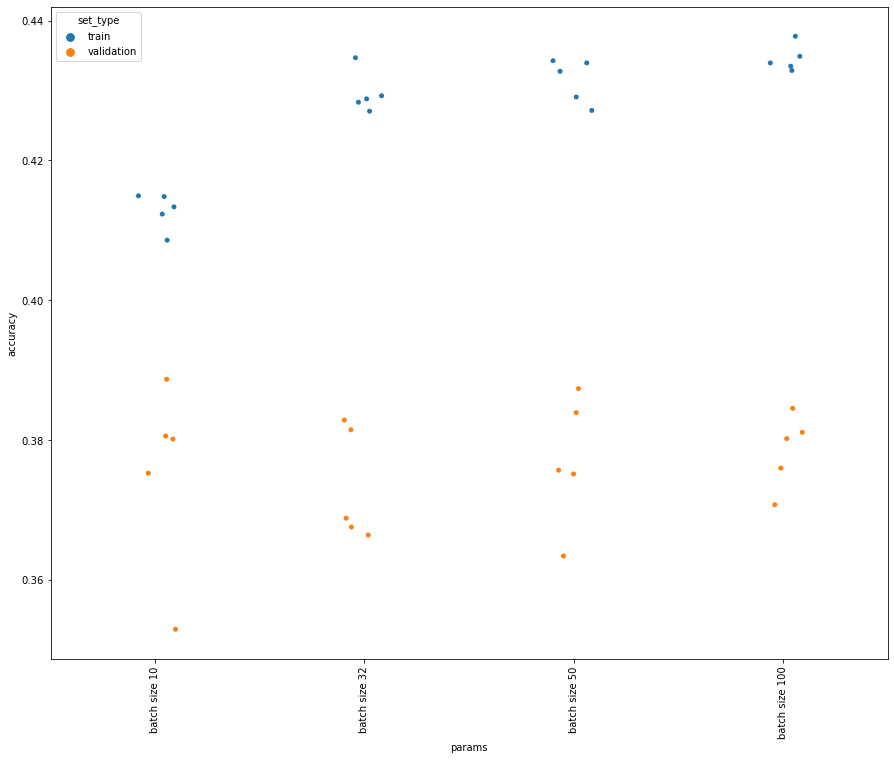

In [206]:
fig5, ax5 = plt.subplots(figsize=(15, 12))
sns.stripplot(
           data=df_to_plot5,
           x='params', 
           y='accuracy', 
           hue='set_type',
           jitter=True, 
           marker='o', 
           ax=ax5
            )
plt.xticks(rotation=90)
plt.show()

Increasing the batch size would provide better training performance but increasing overfitting, without a noticeable increase in validation performance.

### 9.3. Training with the selected parameters

Let's train a model with the following parameters:

1. 3 hidden layers with 2048 512, 128 neurons for the first, second and third layers, respectively.
2. Dropout for the second and third layer.
3. Dropout rate of 0.2.
4. relu as the activation function for the hidden layers.
5. Learning rate of 0.0001 (typically used).
6. Batch size of 10.
7. 1000 epochs.
8. Callback function to stop the training if the validation accuracy gets a value of at least 70%.

In [ ]:
model_params = {'units_per_layer': (2048, 512, 128),
            'dropout': (False, True, True),
            'dropout_rate': 0.2,
            'hidden_layers_activation': 'relu',
            'learning_rate': 0.0001,
            'beta_1': 0.9,
            'beta_2': 0.999,
            'epochs': 1000,
            'batch_size': 10,
            'verbose': 0}

epochs = model_params['epochs']
batch_size = model_params['batch_size']
verbose = model_params['verbose']
model_params.update({'input_shape': X_balanced.shape[1],
                     'output_shape': 8})
model_params = {par: val for par, val in model_params.items() if par not in ['epochs', 'batch_size', 'verbose']}

accuracy_train_list = []
accuracy_validation_list = []

skf = StratifiedKFold(n_splits=5, shuffle=True)

n = 0
for train_index, validation_index in skf.split(X_balanced, y_balanced):
    n =+ 1
    print(f'Validation # {n}')
    X_train, X_validation = X_balanced[train_index], X_balanced[validation_index]
    y_train, y_validation = y_balanced[train_index], y_balanced[validation_index]
    dd_model = annclassifier(**model_params)
    hist = dd_model.fit(X_train, y_train,
                          batch_size=batch_size,
                          verbose=verbose,
                          epochs=epochs,
                          validation_data=(X_validation, y_validation),
                          shuffle=True,
                          callbacks=[myCallback()])
    accuracy_validation_list.append(dd_model.evaluate(X_validation, y_validation, verbose=0)[1])
    accuracy_train_list.append(dd_model.evaluate(X_train, y_train, verbose=0)[1])

Validation # 1


## 10. External validation

### 10.1. Overfitting/underfitting/optimal

For this part, let's use the non-parametric hypothesis test of Mann Whitney U Test (or Wilcoxon Rank Sum Test) to perform an analysis for overfitting and underfitting of the model.

In [ ]:
def overfitting_underfitting(score_train, score_test):
    '''
    Funtion to determine overfitting and underfitting
    Conditions:
    
    1. High test accurracy (>= 0.70)
    2. Small gap between accucaries
    The non-parametric hypothesis test: Mann Whitney U Test (Wilcoxon Rank Sum Test)
    H0: The score_train and  score_test are equal
    H1: The score_train and  score_test are not equal
    5% level of significance (i.e., α=0.05)
    '''

    mean_score_test = round(np.mean(score_test), 2)
    U1, p = mannwhitneyu(score_train,
                        score_test,
                        method="exact")

    if mean_score_test < 0.70:
        if p < 0.05:
            return 'under-fitting (high bias and high variance)'
        else:
            return 'under-fitting (high bias)'
    else:
        if p < 0.05:
            return 'over-fitting (high variance)'
        else:
            return 'optimal-fitting'

### 10.2. Performance on test set

## 11. Conclusions

## 12. Model persistence